# **Creating ner dataset**

Which will contain the following columns: 

- Sentence # : number of the sentence
- Word : tokens 
- IOB Tag: Tags suivant le format d'etiquettage IOB (Inside-Outside-Beginning )
- POS Tag: Part Of Speach Tagging


In [ ]:
import pandas as pd
import math
import numpy as np
from seqeval.metrics import f1_score
from seqeval.metrics import classification_report,accuracy_score,f1_score
import torch.nn.functional as F
import torch
import os
from tqdm import tqdm,trange
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_transformers import BertTokenizer, BertConfig
from pytorch_transformers import BertForTokenClassification, AdamW

In [ ]:
import pandas as pd
import glob
import re
import spacy
import nltk
from nltk import word_tokenize
from nltk.corpus import brown as cb
from nltk.corpus import treebank as tb
import pprint
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import Pipeline

## Step 1

During this step, I'm going to read the .ann files and then to create a dataframe which will contain two columns :

- The ID that appears first on each line ( T1, T2, R1, R2, etc. )
- The rest of the annotation text which is separated from the ID by a single TAB character

In [ ]:
path = r'C:\Users\hajar\Desktop\Corpus\Malware threat reports\annotations' # path of annotated files
all_files = glob.glob(path + "/*.ann")

In [ ]:
# create empty list to hold dataframes from files found
dfs = []
# for each file in the path above ending .ann
for file in all_files:
    #open the file
    df = pd.read_csv(file, sep='^([^\s]*)\s', engine='python', header=None).drop(0, axis=1)
    #add this new (temp during the looping) frame to the end of the list
    dfs.append(df)

At this point we have a list of frames with each list item as one .ann file.  

For example : [annFile1, annFile2, etc.]


In [ ]:
#handle a list that is empty
if len(dfs) == 0:
    print('No files found.')
    #create a dummy frame
    df = pd.DataFrame()
#or have only one item/frame and get it out
elif len(dfs) == 1:
    df = dfs[0]
#or concatenate more than one frame together
else: 
    df = pd.concat(dfs, ignore_index=True)
    df = df.reset_index(drop=True)


In [ ]:
#check what we've got
print(df.head(6))

## Step 2

During the second step, I'm going to keep the entities and get rid of other types of annotation as Relations (R1 , R2 ...), Attributes (A1, A2..) and Events (E1, E2 ..) if they exist. Then, I'm going to split each line to its corresponding Label , offset and keyword. 

In [ ]:
labels=[] #list of labels
start_offset=[] # the start offsets which identifies each word/text in the document
end_offset=[] # the end offsets which identifies each word/text in the document
words=[] # the specific texts connected to each label
ids=[] #the ids of each annotation

In [ ]:
for i in range (df.shape[0]):
    if df[1][i].startswith('T'):
        ids.append(df[1][i])
        labels.append(df[2][i].split(' ')[0])
        words.append(df[2][i].split('\t')[1])
        start_offset.append(df[2][i].split(' ')[1])
        end_offset.append(df[2][i].split(' ')[2].split('\t')[0])

In [ ]:
data={'ID':ids,'Label':labels, 'word':words, 'Start offset':start_offset, 'End offset':end_offset}
annotation=pd.DataFrame(data)

In [ ]:
annotation.head(10)

How many labels do we have ?

In [ ]:
labels=annotation['Label'].unique()
print(labels)
len(annotation['Label'].unique())

we got 50 labels

## Step 3

In [ ]:
i=1 # index of file
annotation['Text File']=''
for r in range (annotation.shape[0]):
    if annotation['ID'][r]=='T1':
        file="File "+str(i)
        annotation['Text File'][r]=file
        i=i+1
    else:
        annotation['Text File'][r]=file 

In [ ]:
annotation.head()

In [ ]:
path = r'C:\Users\hajar\Desktop\Corpus\Malware threat reports\text' # path of text files
all_files = glob.glob(path + "/*.txt")

In [ ]:
# remove extra spaces and ending space if any
spaces = ['\u200b', '\u200e', '\u202a', '\u202c', '\ufeff', '\uf0d8', '\u2061', '\x10', '\x7f', '\x9d', '\xad', '\xa0']
def remove_space(text):
    for space in spaces:
        text = text.replace(space, ' ')
    text = text.strip()
    text = re.sub('\s+', ' ', text)
    return text

In [ ]:
annotation['Sentence']=''
j=0
i=0
for file in all_files:
    j=j+1
    with open(file, 'r', encoding = 'utf-8') as textFile:
        text=textFile.read()
    text= text.replace("\n"," ")
    text= text.replace("("," ")
    text= text.replace(")"," ")
    text= text.replace('“',' ')
    text= text.replace('”',' ')
    text= text.replace('"',' ')
    text = text.replace(". "," .<stop>") 
    text = text.replace("? "," ?<stop>")
    text = text.replace("!"," !<stop>")
    sentences = text.split("<stop>")
    while annotation['Text File'][i]=='File '+str(j):
        b=0
        m=sentences[b]
        while len(m)<int(annotation['Start offset'][i]):
                b=b+1
                m=m+''+sentences[b]
        annotation['Sentence'][i]=sentences[b]
        i=i+1
        if i==annotation.shape[0]:
            break

In [ ]:
annotation.head(20)

In [ ]:
annotation['Sentence'][1]

In [ ]:
import re
annotation['SentencePre']=''
for i in range (annotation.shape[0]):
    m=annotation['Sentence'][i]
    m= m.replace(","," , ")
    m= m.replace(": "," : ")
    m = m.replace(";"," ;")
    m=remove_space(m)
    annotation['SentencePre'][i]=m
annotation.head()

In [ ]:
for t in range (annotation['word'].shape[0]):
    text=annotation['word'][t]
    text= text.replace("(IE)","IE")
    text= text.replace("The","")
    text=remove_space(text)
    annotation['word'][t]=text   
annotation.head()

In [ ]:
annotation.head(10)

In [ ]:
inp=pd.DataFrame({'Text': annotation['SentencePre'].unique().tolist()})
inp.head()

In [ ]:
u = inp.Text.str.split(expand=True).stack()       
data=pd.DataFrame({
    'Sentence': u.index.get_level_values(0) + 1, 
    'Word': u.values, 
})
data.head(20)

In [ ]:
f=annotation.word.str.split(expand=True).stack()
data['Label']=''
for i in range (data.shape[0]):
    if data['Word'][i] not in f.values:
        data['Label'][i]='O'
    else:
        l=[]
        for j in range (annotation.shape[0]):
            if inp['Text'][data['Sentence'][i]-1]==annotation['SentencePre'][j]:
                l=l+(annotation['word'][j].split())
        if data['Word'][i] not in l:
            data['Label'][i]='O'
        else:
            data['Label'][i]='label'

In [ ]:
val=f.values.tolist()
for i in range (data.shape[0]):
    stop=0
    if data['Label'][i]!='O':
        for c in range (len(val)):
            if val[c] == data['Word'][i] and stop==0:
                ii=f.index.get_level_values(0).tolist()[c]
                if type(annotation['Label'][f.index.get_level_values(0)][ii])==str:
                    data['Label'][i]=annotation['Label'][f.index.get_level_values(0)][ii]
                    stop=1
                else:
                    data['Label'][i]=annotation['Label'][f.index.get_level_values(0)][ii].values[0]
                    stop=1
                val[c]='fait'                       

In [ ]:
data.head()

In [ ]:
data.Label.value_counts()

In [ ]:
data1=pd.read_csv('C:/Users/hajar/Downloads/TR5.csv')

In [ ]:
data.shape[0]

In [ ]:
j=0
for i in range (data.shape[0]):
    if data['Label'][i]=='O':
        j=j+1
print(j)

In [ ]:
j=0
for i in range (data.shape[0]):
    if data['Label'][i]=='label':
        data['Label'][i]='O'


##### ---- Partie demo des fonctions utilisées precedemment ( to skip ) 

In [ ]:
annotation.word.str.split(expand=True).stack()

In [ ]:
f=annotation.word.str.split(expand=True).stack()
f.values.tolist()

In [ ]:
annotation['Label'][f.index.get_level_values(0)][2]

### Tags Mapping 

In [ ]:
tagMap = {
    "MD5": "MALWARE",
    "Indicator": "INDICATOR", 
    "Malware": "MALWARE",
    "Time": "DATE",
    "File": "INDICATOR",
    "Address": "MALWARE",
    "ExploitTargetObject": "ExploitTargetObject",
    "Country": "O",
    "Software": "PRODUCT",
    "SHA-1": "INDICATOR",
    "Organization": "ORG",
    "Campaign": "CAMPAIGN",
    "Exploit": "MALWARE",
    "Attacker": "ATTACKER",
    "Vulnerability": "VULNERABILITY",
    "TrojanHorse": "MALWARE",
    "Email": "MALWARE",
    "MalwareCharacteristics": "MALWARECHARACTERISTICS", #UNCHANGED
    "CourseOfAction": "COURSEOFACTION", #UNCHANGED
    "Payload": "MALWARECHARACTERISTICS",
    "Dropper": "MALWARE",
    "Obfuscation": "MALWARECHARACTERISTICS", #UNCHANGED
    "Person": "O",
    "Location": "LOC",
    "SHA-256": "INDICATOR", #UNCHANGED
    "SystemConfigurationInformation": "INFORMATION",
    "MalwareFamily": "MALWAREFAMILY", #UNCHANGED
    "Password": "O", #UNCHANGED
    "Hash": "O", #UNCHANGED
    "SystemInformation": "INFORMATION",
    "AttackerGroup": "ATTACKERGRP",
    "Host": "O", #UNCHANGED
    "Region": "LOC",
    "Information": "INFORMATION",
    "SourceCodeInformation": "INFORMATION",
    "Account": "O", #UNCHANGED
    "TechnologyInformation": "INFORMATION",
    "ThreatActor": "CAMPAIGN",
    "GeneralVirus": "MALWARE",
    "Vector": "MALWARECHARACTERISTICS", #UNCHANGED
    "System": "O", #UNCHANGED
    "BusinessInformation": "INFORMATION",
    "NetworkInformation": "INFORMATION",
    "UserName": "O",
    "FinancialInformation": "INFORMATION",
    "Event": "O",
    "AccountAuthenticationInformation": "INFORMATION",
    "UniquelyIdentifiableInformation": "INFORMATION",
    "EmailAction": "O", #UNCHANGED,
    "Action": "O",
    "ModificationAction": "O"
}

In [ ]:
for i in range (data.shape[0]):
    tag=data['Label'][i]
    if tag!='O':
        for key in tagMap.keys():
            if key==tag:
                data['Label'][i]=tagMap.get(key)
data.head()

##### Adding more reports

In [ ]:
import json

with open('C://Users/hajar/Desktop/annotation.json') as f:
    f = json.load(f)

In [ ]:
Sentence=[]
x=0
sen=[]
for file in f:
    if len(Sentence)!=0:
        x=Sentence[-1]
    for s in range (len(file['sents'])):
        Word=[]
        for w in file['sents'][s]:
            #Sentence.append(s+1+x)
            Word.append(w)
        sen=sen+[Word]    

In [ ]:
len(sen)

In [ ]:
ent=[]
for i in entities:
    ent.append(i.split())

In [ ]:
ent

In [ ]:
set([1,2]).issubset([1,2,3])

In [ ]:
fil=[]
for i in ent:
    stop=False
    for j in sen:
        if set(i).issubset(j) and stop==False:
            fil.append(j) 
            stop=True

In [ ]:
len(fil)

In [ ]:
j=0
w=[]
s=[]
for i in fil:
    j=j+1
    for m in range (len(i)):
        s.append(j)
    w=w+i

In [ ]:
data2=pd.DataFrame({
    'Sentence': Sentence, 
    'Word': Word, 
})
data2.head()

In [ ]:
dat=pd.DataFrame({
    'Sentence': s, 
    'Word': w, 
})
dat.head()

In [ ]:
data2

In [ ]:
data2['Label']='O'
length=0
for file in f:
    for s in range (len(file['vertexSet'])):
        for l in file['vertexSet'][s]:
            position=0
            if l['sent_id']==0:
                position = position + length
            else:
                for k in range (l['sent_id']):
                       position = position + len(file['sents'][k]) + length
            pos_start = l['pos'][0] + position
            pos_end = l['pos'][1] + position
            label=l['type']
            data2['Label'][pos_start:pos_end]=label
    for sen in file['sents']:
        length = length + len(sen)

In [ ]:
data2['Sentence']=data2['Sentence']+1727
data2.head()

In [ ]:
data2.tail()

In [ ]:
data2['Label'].unique()

In [ ]:
import json

with open('C://Users/hajar/Desktop/malware reports 2.json') as f1:
    f1 = json.load(f1)

In [ ]:
Sentence=[]
Word=[]
x=0
for file in f1:
    if len(Sentence)!=0:
        x=Sentence[-1]
    for s in range (len(file['sents'])):
        for w in file['sents'][s]:
            Sentence.append(s+1+x)
            Word.append(w)

In [ ]:
data3=pd.DataFrame({
    'Sentence': Sentence, 
    'Word': Word, 
})
data3.head()

In [ ]:
data3['Label']='O'
length=0
for file in f1:
    for s in range (len(file['vertexSet'])):
        for l in file['vertexSet'][s]:
            position=0
            if l['sent_id']==0:
                position = position + length
            else:
                for k in range (l['sent_id']):
                       position = position + len(file['sents'][k]) + length
            pos_start = l['pos'][0] + position
            pos_end = l['pos'][1] + position
            label=l['type']
            data3['Label'][pos_start:pos_end]=label
    for sen in file['sents']:
        length = length + len(sen)

In [ ]:
data3['Sentence']=data3['Sentence']+11849

In [ ]:
data3.head()

In [ ]:
data3['Label'].unique()

In [ ]:
data

In [ ]:
data1['Sentence']=data1['Sentence']+1811
data1.head()

In [ ]:
d=pd.DataFrame({'Sentence':data1['Sentence'].tolist(), 'Word': data1['Word'].tolist(), 'Label':data1['Label'].tolist()})

In [ ]:
frames=[data,d]
df = pd.concat(frames)
df

In [ ]:
df.reset_index(drop=True, inplace=True)

In [ ]:
df['Label'].unique()

## IOB tagging

In [ ]:
def iob(data):
    new_tags = []
    
    if data["Label"][0] != "O":
        new_tags.append(f"B-{data['labels'][0]}")
    else:
        new_tags.append("O")
    
    for idx in range(1, len(data["Label"])):
        current_tag = data['Label'][idx]
        if current_tag == "O":
            new_tags.append(current_tag)
        elif data["Label"][idx-1] != current_tag :
            new_tags.append(f"B-{current_tag}")
        else:
            new_tags.append(f"I-{current_tag}")
            
    data["iob_tag"] = new_tags
    return data

In [ ]:
df=iob(df)
df.head()

##### ---- Partie brouillon ( to skip ) 

In [ ]:
sentence=[]
for file in all_files:
    with open(file, 'r', encoding = 'utf-8') as textFile:
        text=textFile.read()
    text= text.replace("\n"," ")
    text= text.replace('“',' ')
    text= text.replace('”',' ')
    text= text.replace('"',' ')
    text= text.replace("("," ")
    text= text.replace(")"," ")
    text= text.replace(": "," : ")
    text = text.replace(". "," .<stop>") 
    text= text.replace(","," , ")
    text = text.replace("? "," ?<stop>")
    text = text.replace("!"," !<stop>")
    text = text.replace(";"," ;")
    sentence = sentence + text.split("<stop>")

In [ ]:
phrase=[]
for s in sentence:
    s=remove_space(s)
    phrase.append(s)   

In [ ]:
df=pd.DataFrame({'Text': phrase})
df.head(40)

In [ ]:
annotation['SentencePre'][10]

In [ ]:
df['Text'][27]

In [ ]:
for i in annotation['SentencePre']:
       if i not in df['Text'].tolist():
            print(i)

In [ ]:
df['Text'][95]

In [ ]:
u = df.Text.str.split(expand=True).stack()

data=pd.DataFrame({
    'Sentence': u.index.get_level_values(0) + 1, 
    'Word': u.values, 
})
data.head(20)

In [ ]:
entities=annotation['word'].tolist()
entities

In [ ]:
entities=[]
for text in annotation['word'].tolist():
    text= text.replace("(IE)","IE")
    text= text.replace("The","")
    text=remove_space(text)
    entities.append(text)
entities    

In [ ]:
entity_tag=[]
for e in range (len(entities)) :
    split_entity=entities[e].split(" ")
    j=0
    for i in split_entity:
        if j==0:
            entity_tag.append((i , "B-"+annotation['Label'][e]))
            j=1
        else:
            entity_tag.append((i , "I-"+annotation['Label'][e]))
    

In [ ]:
entity_tag

In [ ]:
len(entity_tag)

In [ ]:
entity_token=[]
for i in entity_tag:
    entity_token.append(i[0])
##Tag column
data['Tag']=""
for i in range (data.shape[0]):
    stop=0
    if (data['Word'][i] in entity_token) and (df['Text'][data['Sentence'][i]-1] in annotation['SentencePre'].tolist()):
            for tok in entity_tag :
                 if tok[0]==data['Word'][i] and stop==0:
                        data['Tag'][i]=tok[1]
                        entity_tag.remove(tok) 
                        stop=1
    else:
        if df['Text'][data['Sentence'][i]-1] in annotation['SentencePre'].tolist():
                data['Tag'][i]='O' #doesn't belong to any tag
        else:
                data['Tag'][i]='to delete' #I decided to delete sentences that do not contain any entity 
#data = data.loc[(data["Tag"]!='to delete')]

In [ ]:
entity_token

In [ ]:
s=data.drop(data[(data['Tag'] == 'to delete')].index)

In [ ]:
data['Tag'].unique()

In [ ]:
s.head(10)

In [ ]:
entity_token

## POS Tagging

###### What is Parts of Speech?

Parts of Speech (POS): POS helps us to get an idea how a particular word or a phrase used in a given sentence in order to convey the logical meaning of the sentence.

It is important to know the category of the words that helps us to form logical meaning of the sentence for any given language

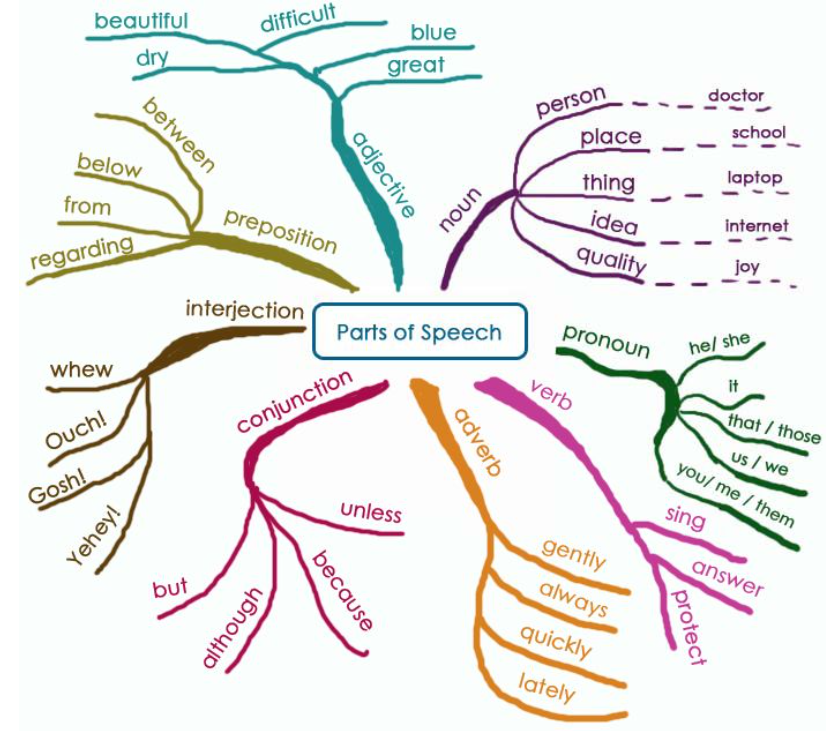

#### Why do we need to build our own statistical POS tagger form scratch ?

- Dealing with domain specific terminology

- Dealing with ambiguity

##### Idea -> To consider tagged dataset / corpus as input and apply supervised Machine Learning algorithm.

### Download Brown corpus

This Standard Corpus of Present-Day American English consists of 1,014,312 wordsl of running text of edited English prose printed in the United States during the calendar year 1961

In [ ]:
nltk.download('brown')

### Download Penn Treebank corpus

English POS Tagset

It contains 36 tags

In [ ]:
nltk.download('treebank')

### Import dependencies

In [ ]:
from nltk import word_tokenize
from nltk.corpus import brown as cb
from nltk.corpus import treebank as tb
import pprint
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import Pipeline

##### Explore the brown corpus

In [ ]:
raw_text = nltk.Text(cb.words('ca01'))
print (raw_text)

In [ ]:
print (cb.words()[0:20])

In [ ]:
print (cb.tagged_words()[0:10])

In [ ]:
tagged_sentences_brown_corpus = nltk.corpus.brown.tagged_sents()
pprint.pprint(tagged_sentences_brown_corpus[0])

##### Explore the treebank corpus

In [ ]:
raw_text = nltk.Text(tb.words()[0:10])
print (raw_text)

In [ ]:
print (tb.words()[0:10])

In [ ]:
tagged_sentences_treebank_corpus = nltk.corpus.treebank.tagged_sents()
pprint.pprint (tagged_sentences_treebank_corpus[0])

  ######                           I will be using Treebank corpus to build the POS tagger

In [ ]:
print ("Tagged sentences: ", len(tagged_sentences_treebank_corpus))

In [ ]:
print ("Tagged words:", len(nltk.corpus.treebank.tagged_words()))

### Generate features

In [ ]:
def features(sentence, index):
    # "sentence: [w1, w2, ...], index: the index of the word"
    return {
    'word': sentence[index],
    'is_first': index == 0,
    'is_last': index == len(sentence) - 1,
    'is_capitalized': sentence[index][0].upper() == sentence[index][0],
    'is_all_caps': sentence[index].upper() == sentence[index],
    'is_all_lower': sentence[index].lower() == sentence[index],
    'prefix-1': sentence[index][0],
    'prefix-2': sentence[index][:2],
    'prefix-3': sentence[index][:3],
    'suffix-1': sentence[index][-1],
    'suffix-2': sentence[index][-2:],
    'suffix-3': sentence[index][-3:],
    'prev_word': '' if index == 0 else sentence[index - 1],
    'next_word': '' if index == len(sentence) - 1 else sentence[index + 1],
    'has_hyphen': '-' in sentence[index],
    'is_numeric': sentence[index].isdigit(),
    'capitals_inside': sentence[index][1:].lower() != sentence[index][1:]
    }

In [ ]:
pprint.pprint(features(['This', 'is', 'a', 'sentence'], 0))

### transform dataset

Extract words form tagged sentences using 'untag' function

In [ ]:
def untag(tagged_sentence):
    return [w for w, t in tagged_sentence]

 X = Features , y = POS lables

In [ ]:
def transform_to_dataset(tagged_sentences):
    X, y = [], []
    for tagged in tagged_sentences:
        for index in range(len(tagged)):
            X.append(features(untag(tagged), index))
            y.append(tagged[index][1])
            
    return X, y

training and testing dataset

In [ ]:
cutoff = int(.75 * len(tagged_sentences_treebank_corpus))
training_sentences = tagged_sentences_treebank_corpus[:cutoff]
test_sentences = tagged_sentences_treebank_corpus[cutoff:]

In [ ]:
print (len(training_sentences))
print (len(test_sentences))

In [ ]:
X, y = transform_to_dataset(training_sentences)

In [ ]:
print(len(X)) 
print(len(y))

### Training

In [ ]:
#initialize classifier
clf = Pipeline([
    ('vectorizer', DictVectorizer(sparse=False)),
    ('classifier', DecisionTreeClassifier(criterion='entropy'))
])

In [ ]:
clf.fit(X[:20000],y[:20000]) 

### Mesure accuracy

In [ ]:
X_test, y_test = transform_to_dataset(test_sentences)

In [ ]:
print ("Accuracy:{:.3%}".format(clf.score(X_test, y_test)))

### Generate POS Tags for our data

In [ ]:
def pos_tag(sentence):
    tagged_sentence = []
    tags = clf.predict([features(sentence, index) for index in range(len(sentence))])
    return zip(sentence, tags)

In [ ]:
POS_list = list(pos_tag(word_tokenize('Hi, I am hajar')))

In [ ]:
POS_list

In [ ]:
sec=df
sec

In [ ]:
df.Label.value_counts()

In [ ]:
df=pd.DataFrame({
    'Sentence #':df['Sentence'],
    'Word':df['Word'],
    'Tag':df['iob_tag'],
})

In [ ]:
df['POS']=""
for i in range (df.shape[0]):
    text=inp['Text'][df['Sentence #'][i]-1]
    pos_list=list(pos_tag(word_tokenize(text)))
    for idx in range (len(pos_list)):
        if pos_list[idx][0]==df['Word'][i]:
            df['POS'][i]=pos_list[idx][1]
            pos_list[idx]=('done','done')

In [ ]:
df.head(20)

In [ ]:
df['Label'].unique()

In [ ]:
df.to_csv("C://Users/hajar/Desktop/MTR.csv") 